Import Libraries


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Tree-based models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# Models that need scaling
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Advanced boosting models

!pip install xgboost
!pip install catboost
!pip install lightgbm
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


Load and Explore Data

In [5]:
# Load the dataset
df = pd.read_csv('Nigeria Crash Data Shuffled.csv')

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
df.head()

Dataset shape: (518, 72)

First 5 rows:


,Quarter,State,Total_Crashes,Num_Injured,Num_Killed,Total_Vehicles_Involved,SPV,DAD,PWR,FTQ,...,State_Taraba,State_Yobe,State_Zamfara,Region,Region_Encoded,Region_North East,Region_North West,Region_South East,Region_South South,Region_South West
0,Q2 2022,Ogun,143,107,1,31,1,0,0,0,...,False,False,False,South South,5,False,False,False,False,False
1,Q1 2023,Bayelsa,241,442,12,78,10,0,0,0,...,False,False,False,South South,3,False,False,False,False,False
2,Q3 2023,Sokoto,73,65,96,100,70,0,1,0,...,False,False,False,North West,2,True,False,False,False,False
3,Q3 2021,Kano,75,262,9,177,19,0,0,19,...,False,False,False,South West,2,False,True,False,False,False
4,Q4 2022,Plateau,151,201,21,328,105,0,0,62,...,False,False,False,South West,4,False,False,True,False,False


Preprocessing – Feature & Target Selection

In [6]:
# Define target
target = 'Total_Casualties'

# Columns to drop (identifiers, target-derived, or redundant)
cols_to_drop = [
    'Quarter', 'State', 'Num_Injured', 'Num_Killed', 'Quarter_Date',
    'Casualty_Rate', 'Fatality_Rate', 'Vehicles_per_Crash', 'Total_Factors',
    'SPV_Prop', 'DAD_Prop', 'PWR_Prop', 'FTQ_Prop', 'Other_Factors_Prop',
    'Severe_Crash', 'High_Casualty', 'State_Encoded', 'Region', 'Region_Encoded'
]

# Keep all state dummies (columns starting with 'State_')
state_dummies = [col for col in df.columns if col.startswith('State_')]

# Keep all region dummies (columns starting with 'Region_' except 'Region' and 'Region_Encoded')
region_dummies = [col for col in df.columns if col.startswith('Region_') and col not in ['Region', 'Region_Encoded']]

# Other numeric features to keep
other_features = [
    'Total_Crashes', 'Total_Vehicles_Involved', 'SPV', 'DAD', 'PWR', 'FTQ',
    'Other_Factors', 'Quarter_Num', 'Year', 'Quarter_Sin', 'Quarter_Cos'
]

# Combine all feature columns
feature_cols = other_features + state_dummies + region_dummies

# Ensure all features exist
feature_cols = [col for col in feature_cols if col in df.columns]

print("Number of features:", len(feature_cols))
print("Features:", feature_cols[:10], "...")  # show first 10

# Create feature matrix X and target vector y
X = df[feature_cols].copy()
y = df[target].copy()

# Check for missing values
print("\nMissing values in X:", X.isnull().sum().sum())
print("Missing values in y:", y.isnull().sum())

# Drop rows with missing values (if any)
if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    combined = pd.concat([X, y], axis=1).dropna()
    X = combined[feature_cols]
    y = combined[target]
    print("After dropping missing, shape:", X.shape)

Number of features: 53
Features: ['Total_Crashes', 'Total_Vehicles_Involved', 'SPV', 'DAD', 'PWR', 'FTQ', 'Other_Factors', 'Quarter_Num', 'Year', 'Quarter_Sin'] ...

Missing values in X: 0
Missing values in y: 0


Train-Test Split

In [7]:
# Split into training and testing sets (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (414, 53)
Test set size: (104, 53)


Define Models and Evaluation Function

In [8]:
# Model specifications as given
MODEL_SPECS = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "ExtraTrees": ExtraTreesRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "MLP": MLPRegressor(random_state=42),          # needs scaling
    "KNN": KNeighborsRegressor(),                  # needs scaling
    "SVR": SVR(),                                   # needs scaling
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0),
    "LightGBM": LGBMRegressor(random_state=42, verbose=-1)
}

# Models that require feature scaling
scaling_required = ['MLP', 'KNN', 'SVR']

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Fit model, predict, and return metrics."""
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    return {
        'Model': model_name,
        'Train R2': train_r2,
        'Test R2': test_r2,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae
    }

Train All Models and Collect Results

In [9]:
results = []

for name, model in MODEL_SPECS.items():
    print(f"Training {name}...")
    if name in scaling_required:
        # Create pipeline with scaler
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', model)
        ])
    else:
        pipeline = model

    # Evaluate
    metrics = evaluate_model(pipeline, X_train, y_train, X_test, y_test, name)
    results.append(metrics)

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test R2', ascending=False).reset_index(drop=True)
print("\nModel Performance (sorted by Test R2):")
results_df

Training LinearRegression...
Training Ridge...
Training Lasso...
Training RandomForest...
Training GradientBoosting...
Training ExtraTrees...
Training DecisionTree...
Training AdaBoost...
Training MLP...
Training KNN...
Training SVR...
Training XGBoost...
Training CatBoost...
Training LightGBM...

Model Performance (sorted by Test R2):


,Model,Train R2,Test R2,Train RMSE,Test RMSE,Train MAE,Test MAE
0,SVR,-0.084153,-0.072638,251.015818,208.062044,176.002137,153.247781
1,RandomForest,0.844367,-0.192527,95.105858,219.381697,71.703792,178.482308
2,Lasso,0.115556,-0.200720,226.720586,220.133955,173.142006,183.119611
3,AdaBoost,0.087647,-0.237151,230.269988,223.448617,199.193646,190.416732
4,GradientBoosting,0.632474,-0.256584,146.150369,225.196696,109.754739,184.752335
5,LightGBM,0.848189,-0.283593,93.930568,227.604028,68.623564,184.263104
6,CatBoost,0.958830,-0.301972,48.915709,229.227677,35.398920,188.544164
7,Ridge,0.138546,-0.310490,223.754596,229.976316,171.668464,193.414293
8,LinearRegression,0.139578,-0.358702,223.620437,234.168434,171.557702,196.747082
9,KNN,0.171001,-0.418685,219.499197,239.281513,165.972464,193.663462


Visualize Model Performance

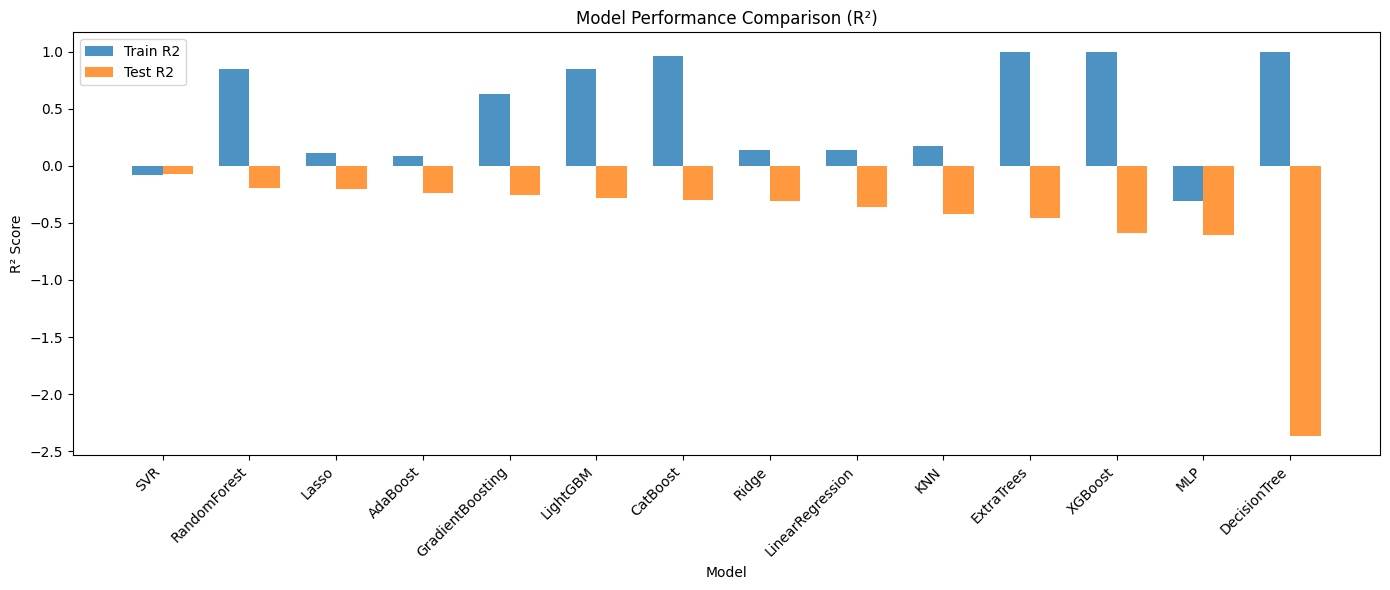

In [14]:
# Bar plot of Train vs Test R2
plt.figure(figsize=(14, 6))
x = range(len(results_df))
width = 0.35

plt.bar(x, results_df['Train R2'], width, label='Train R2', alpha=0.8)
plt.bar([i + width for i in x], results_df['Test R2'], width, label='Test R2', alpha=0.8)

plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison (R²)')
plt.xticks([i + width/2 for i in x], results_df['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

Save Individual Model Metrics to Text Files

In [15]:
import os

# Create a directory to store results
os.makedirs('model_performance', exist_ok=True)

for _, row in results_df.iterrows():
    model_name = row['Model']
    filename = f"model_performance/{model_name}.txt"
    with open(filename, 'w') as f:
        f.write(f"Model: {model_name}\n")
        f.write("="*30 + "\n")
        f.write(f"Train R²   : {row['Train R2']:.4f}\n")
        f.write(f"Test  R²   : {row['Test R2']:.4f}\n")
        f.write(f"Train RMSE : {row['Train RMSE']:.2f}\n")
        f.write(f"Test  RMSE : {row['Test RMSE']:.2f}\n")
        f.write(f"Train MAE  : {row['Train MAE']:.2f}\n")
        f.write(f"Test  MAE  : {row['Test MAE']:.2f}\n")

print("All model performance files saved in 'model_performance/' folder.")

All model performance files saved in 'model_performance/' folder.
